In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import seaborn as sns
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12082\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os
current_dir = os.getcwd()

In [3]:
data1_dir = os.path.join(current_dir, "kaggle","spam_ham_dataset.csv")
data2_dir = os.path.join(current_dir, "kaggle","spamhamdata.csv")
data3_dir = os.path.join(current_dir, "kaggle","email_classification.csv")

In [4]:
data1 = pd.read_csv(data1_dir)
data2 = pd.read_csv(data2_dir, encoding='cp1252', on_bad_lines='skip', sep='\t', header=None)
data3 = pd.read_csv(data3_dir, encoding='cp1252', on_bad_lines='skip')


In [5]:
data3.head()

,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham


In [6]:
data3 = data3.rename(columns = {"email" : "text", "label":"Label"})
data3["Label"] = [1 if i == "spam" else 0 for i in data3["Label"]]

In [7]:
data3.head()

,text,Label
0,Upgrade to our premium plan for exclusive acce...,0
1,Happy holidays from our team! Wishing you joy ...,0
2,We're hiring! Check out our career opportuniti...,0
3,Your Amazon account has been locked. Click her...,1
4,Your opinion matters! Take our survey and help...,0


In [8]:
data1.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [9]:
data1 = data1.drop(['Unnamed: 0', 'label'], axis=1)
data1 = data1.rename(columns = {"label_num" : "Label"})
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5171 non-null   object
 1   Label   5171 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.9+ KB


<Axes: xlabel='Label', ylabel='count'>

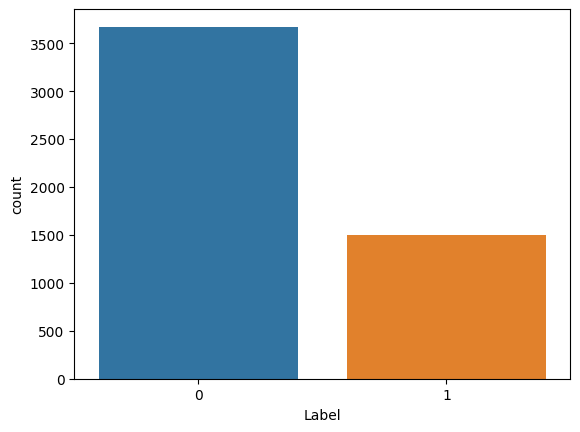

In [10]:
sns.countplot(x="Label", data = data1)

In [11]:
data2.columns=['Label','Message_body']
data2.head()

,Label,Message_body
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
data2 = data2.rename(columns = {"Message_body" : "text"})
data2["Label"] = [1 if i == "spam" else 0 for i in data2["Label"]]
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


<Axes: xlabel='Label', ylabel='count'>

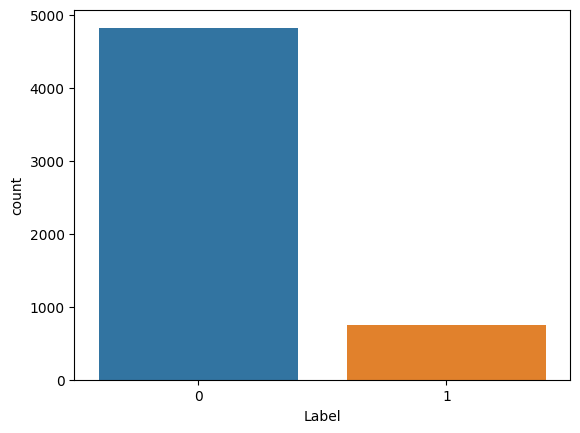

In [13]:
sns.countplot(x = "Label", data = data2)

In [14]:
frames = [data1, data2, data3]
data = pd.concat(frames)
data

,text,Label
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...
174,We're pleased to inform you that your refund h...,0
175,Get rich quick! Invest in our revolutionary ne...,1
176,Your free trial period is ending soon. Upgrade...,0
177,Your order is on its way! Track your shipment ...,0


<Axes: xlabel='Label', ylabel='count'>

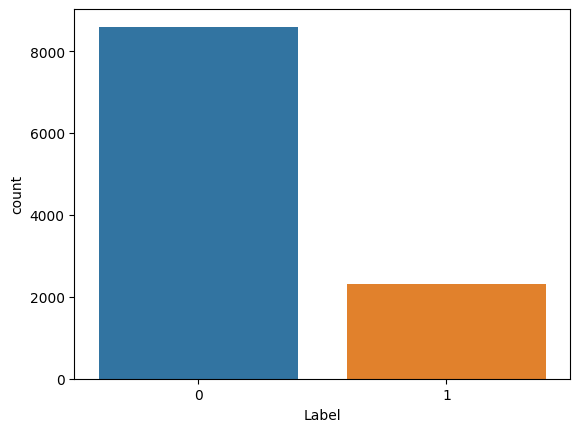

In [15]:
sns.countplot(x="Label", data = data)

Text(0.5, 1.0, 'Spam Word Cloud')

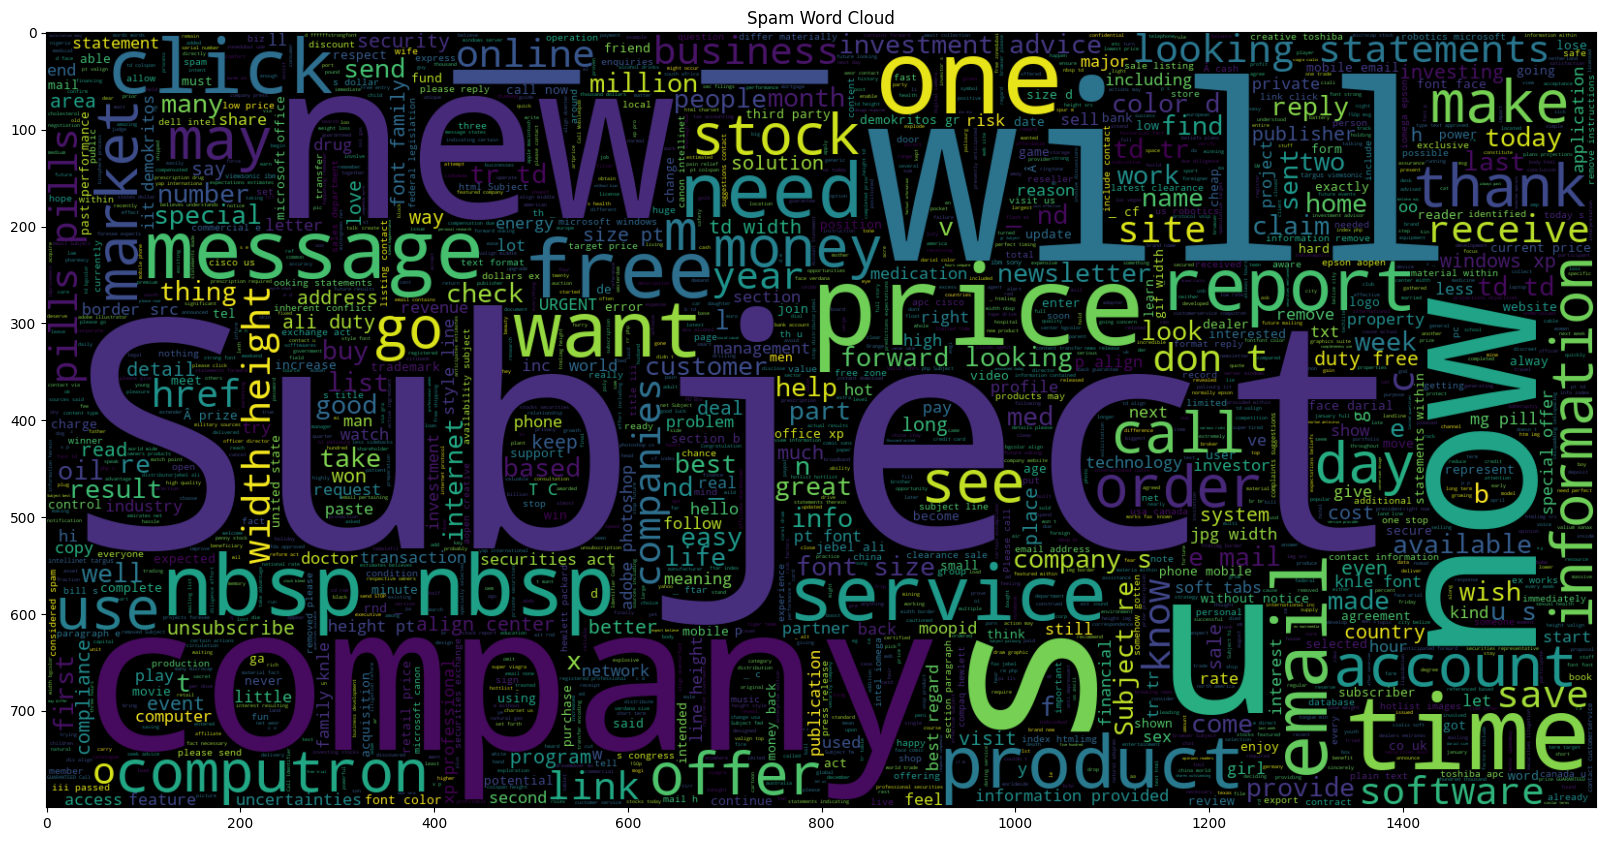

In [16]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.Label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Spam Word Cloud")

Text(0.5, 1.0, 'Ham Word Cloud')

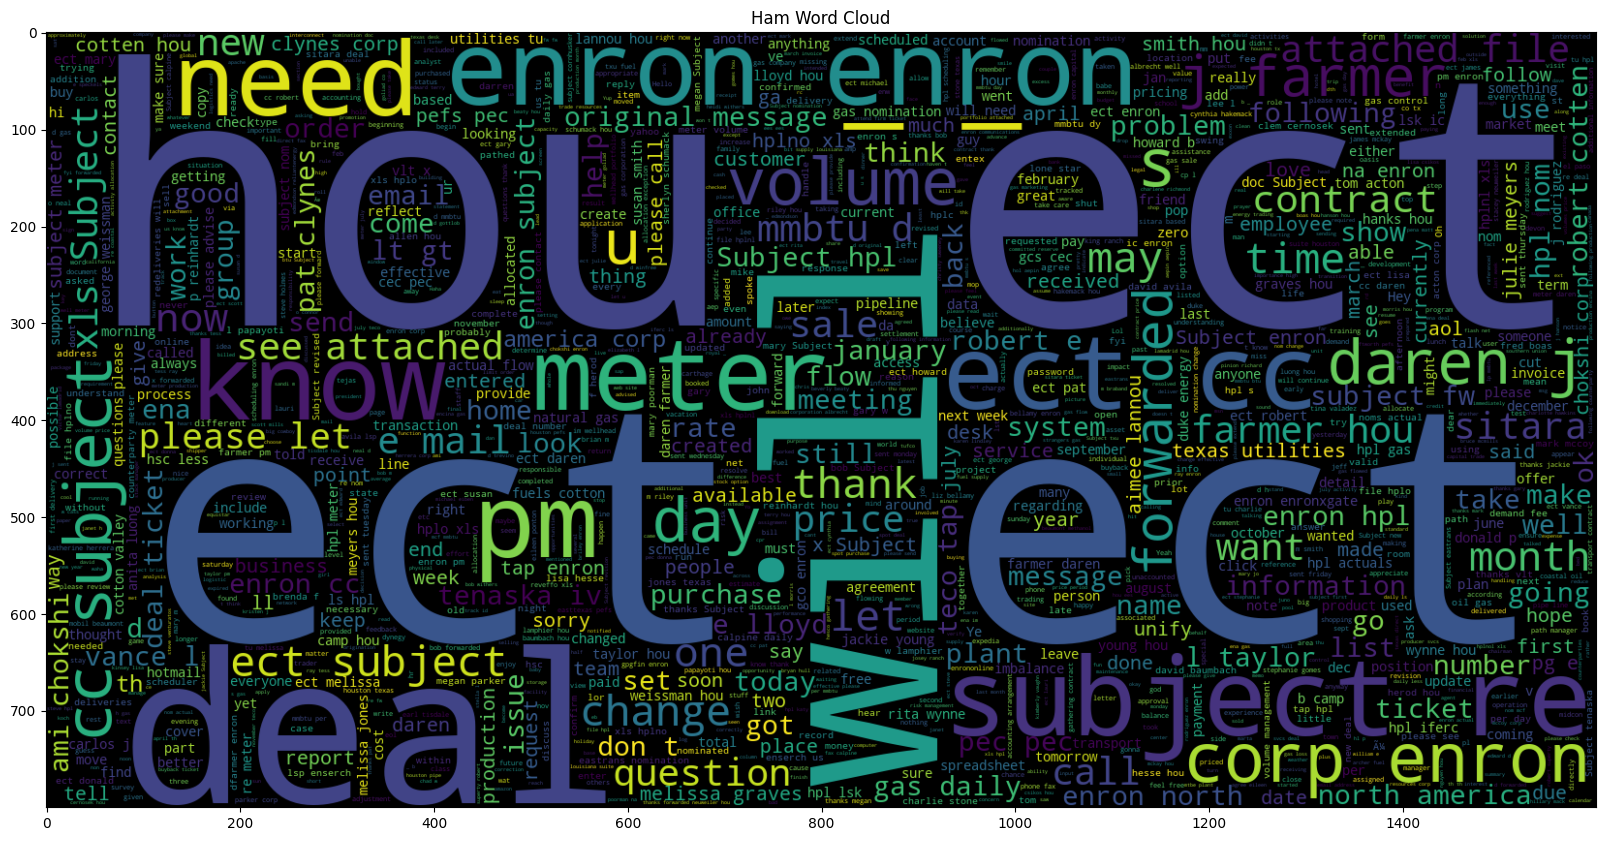

In [17]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.Label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Ham Word Cloud")

In [18]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"

In [19]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data.text = data.text.apply(lambda x: preprocess(x))
data.head()

,text,Label
0,subject: enron methanol ; meter # : 988291 fol...,0
1,"subject: hpl nom january 9 , 2001 ( see attach...",0
2,"subject: neon retreat ho ho ho , ' around wond...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: : indian springs deal book teco pvr r...,0


In [20]:
x = data['text']
y = data['Label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                         random_state=7)
print("Train Data size:", len(x_train))
print("Test Data size", len(x_test))

Train Data size: 8737
Test Data size 2185


In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1000
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 49061


In [22]:
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train),
                        maxlen = 50)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),
                       maxlen = 50)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (8737, 50)
Testing X Shape: (2185, 50)


In [23]:
MAX_SEQUENCE_LENGTH = 50
n_lstm = 200
drop_lstm =0.2

In [24]:
embeding_dim = 16
drop_value = 0.2
n_dense = 24
num_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=5)
optimizer = Adam(learning_rate=0.001)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [25]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=False)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

In [26]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])

In [27]:
history2 = model.fit(x_train, y_train, epochs=num_epochs,
                    validation_data=(x_test, y_test),
                    verbose=2)

Epoch 1/100


274/274 - 44s - loss: 0.2327 - accuracy: 0.9129 - val_loss: 0.0933 - val_accuracy: 0.9670 - 44s/epoch - 161ms/step
Epoch 2/100
274/274 - 39s - loss: 0.0651 - accuracy: 0.9802 - val_loss: 0.0699 - val_accuracy: 0.9789 - 39s/epoch - 143ms/step
Epoch 3/100
274/274 - 64s - loss: 0.0303 - accuracy: 0.9915 - val_loss: 0.0789 - val_accuracy: 0.9776 - 64s/epoch - 234ms/step
Epoch 4/100
274/274 - 67s - loss: 0.0168 - accuracy: 0.9961 - val_loss: 0.1248 - val_accuracy: 0.9712 - 67s/epoch - 245ms/step
Epoch 5/100
274/274 - 72s - loss: 0.0324 - accuracy: 0.9915 - val_loss: 0.2004 - val_accuracy: 0.9268 - 72s/epoch - 262ms/step
Epoch 6/100
274/274 - 69s - loss: 0.0275 - accuracy: 0.9924 - val_loss: 0.1509 - val_accuracy: 0.9703 - 69s/epoch - 252ms/step
Epoch 7/100
274/274 - 68s - loss: 0.0166 - accuracy: 0.9967 - val_loss: 0.1029 - val_accuracy: 0.9803 - 68s/epoch - 250ms/step
Epoch 8/100
274/274 - 69s - loss: 0.0113 - accuracy: 0.9971 - val_loss: 0.1078 - val_accuracy: 0.9698 - 69s/e

9/9 [==============================] - 1s 154ms/step


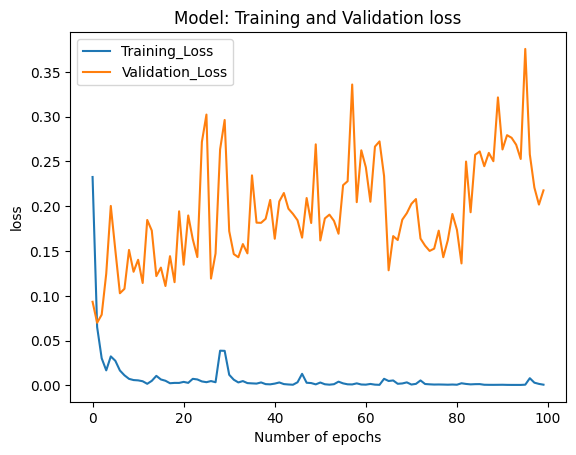

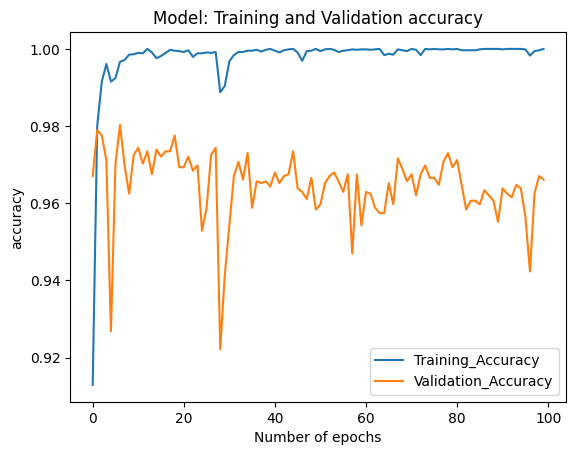

In [28]:
metrics = pd.DataFrame(history2.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')
# make predictions
trainPredict3 = model.predict(x_train, batch_size=256)
model.reset_states()
testPredict3 = model.predict(x_test, batch_size=256)

In [29]:
# Make predictions
test_predictions = model.predict(x_test, batch_size=256)
test_predictions_classes = (test_predictions > 0.5).astype('int32')

9/9 [==============================] - 1s 153ms/step


In [30]:
# Calculate metrics
confusion = confusion_matrix(y_test, test_predictions_classes)
accuracy = accuracy_score(y_test, test_predictions_classes)
precision = precision_score(y_test, test_predictions_classes)
recall = recall_score(y_test, test_predictions_classes)
f1 = f1_score(y_test, test_predictions_classes)

In [31]:
print("Confusion Matrix:\n", confusion)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Confusion Matrix:
 [[1696   29]
 [  45  415]]
Accuracy: 0.97
Precision: 0.93
Recall: 0.90
F1 Score: 0.92


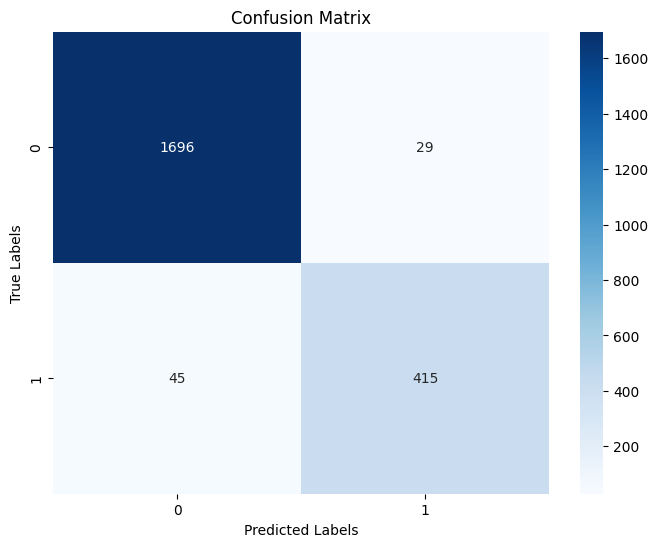

In [32]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Example real email text
email_text = ["Dear User, you have won a lottery of $1,000,000. Click here to claim your prize!"]

# Preprocess the email
email_sequence = tokenizer.texts_to_sequences(email_text)
email_padded = pad_sequences(email_sequence, maxlen=50)  # Use the same `maxlen` as training

# Make predictions
prediction = model.predict(email_padded)

# Output prediction
if prediction > 0.5:  # Adjust threshold if needed
    print("Spam")
else:
    print("Not Spam")

1/1 [==============================] - 0s 31ms/step
Spam


In [34]:
email_texts = [
    "Congratulations! You've won a free vacation. Click to redeem.",
    "Hi, just following up on our meeting scheduled for tomorrow at 10 AM."
]

email_sequences = tokenizer.texts_to_sequences(email_texts)
email_padded = pad_sequences(email_sequences, maxlen=50)

predictions = model.predict(email_padded)

for i, prediction in enumerate(predictions):
    label = "Spam" if prediction > 0.5 else "Not Spam"
    print(f"Email {i+1}: {label}")

1/1 [==============================] - 0s 34ms/step
Email 1: Spam
Email 2: Not Spam


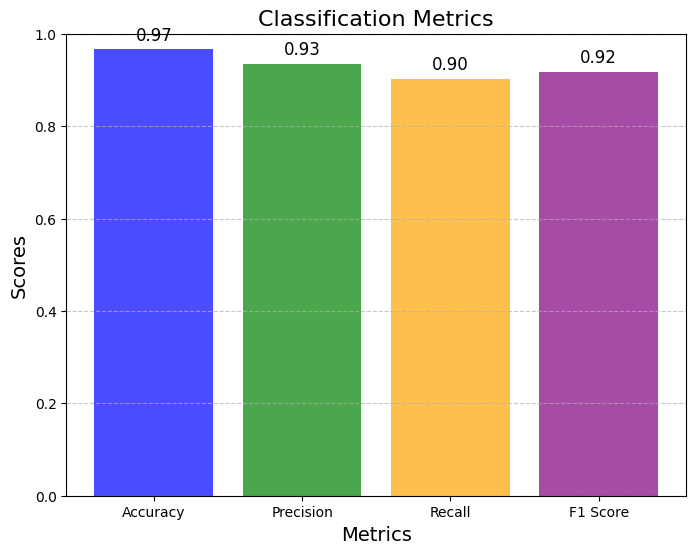

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Example values (replace with your calculated metrics)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]  # Replace with your actual computed values

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple'], alpha=0.7)
plt.ylim(0, 1)  # Metrics range between 0 and 1
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Classification Metrics', fontsize=16)

# Add value annotations
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
